#### 삼전 주가 이용하여 RNN 시계열 예측
    - 정규화
    - Open, Close 컬럼을 10개의 타임스텝으로, 라벨은 Adj Close로
    - RNN 학습
    - 2017~2020 : train set / 2021~현재 : test set으로 구성,
      실제 데이터와 test 예측값을 그래프로 그리시오

In [114]:
from numpy import array
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

#### 데이터 불러오기

In [101]:
df = data.get_data_yahoo('005930.KS', '2017-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-02,36240.0,35880.0,35980.0,36100.0,4650600.0,31468.945312
2017-01-03,36620.0,36020.0,36280.0,36480.0,7357650.0,31800.203125
2017-01-04,36520.0,36100.0,36500.0,36160.0,7971750.0,31521.246094
2017-01-05,36060.0,35540.0,36060.0,35560.0,10967450.0,30998.214844
2017-01-06,36440.0,36040.0,36180.0,36200.0,8880950.0,31556.117188
...,...,...,...,...,...,...
2022-01-06,77600.0,76600.0,76700.0,76900.0,12931954.0,76900.000000
2022-01-07,78400.0,77400.0,78100.0,78300.0,15163757.0,78300.000000
2022-01-10,78100.0,77100.0,78100.0,78000.0,9947422.0,78000.000000


In [102]:
train = df['2017-01-01':'2020-12-31']
test = df['2021-01-01':]

#### 데이터 메이킹

In [103]:
#특성 데이터가 2개 이상일 경우 사용
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

#### 정규화

In [104]:
scaler_x = MinMaxScaler()
x_train_scd = pd.DataFrame(scaler_x.fit_transform(train[['Open','Close']]), columns=['Open','Close'], index=train.index)
x_test_scd = pd.DataFrame(scaler_x.transform(test[['Open','Close']]), columns=['Open','Close'], index=test.index)

scaler_y = MinMaxScaler()
y_train_scd =  pd.DataFrame(scaler_y.fit_transform(train[['Adj Close']]), columns=['Adj Close'], index=train.index)
y_test_scd = pd.DataFrame(scaler_y.transform(test[['Adj Close']]), columns=['Adj Close'], index=test.index)

In [106]:
def split_xy3(dataset, dstaset2, time_steps):
    x, y = list(), list()
    for i in range(len(dataset)):
        end_number = i + time_steps
        if end_number > len(dataset) -1:
            break
        tmp_x, tmp_y = dataset.iloc[i:end_number], dstaset2.iloc[end_number]
        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x), np.array(y)

In [107]:
x_train, y_train = split_xy3(x_train_scd, y_train_scd, 10)
x_test, y_test = split_xy3(x_test_scd, y_test_scd, 10)
x_train

array([[[0.        , 0.0118838 ],
        [0.0069735 , 0.02024648],
        [0.0120874 , 0.01320423],
        ...,
        [0.0357973 , 0.05985915],
        [0.0469549 , 0.07130282],
        [0.0492794 , 0.04181338]],

       [[0.0069735 , 0.02024648],
        [0.0120874 , 0.01320423],
        [0.0018596 , 0.        ],
        ...,
        [0.0469549 , 0.07130282],
        [0.0492794 , 0.04181338],
        [0.0204556 , 0.02420775]],

       [[0.0120874 , 0.01320423],
        [0.0018596 , 0.        ],
        [0.004649  , 0.01408451],
        ...,
        [0.0492794 , 0.04181338],
        [0.0204556 , 0.02420775],
        [0.013947  , 0.03080986]],

       ...,

       [[0.87215249, 0.83274648],
        [0.87447699, 0.8415493 ],
        [0.87912599, 0.8415493 ],
        ...,
        [0.84890748, 0.80853873],
        [0.84658298, 0.84375   ],
        [0.88609949, 0.92957746]],

       [[0.87447699, 0.8415493 ],
        [0.87912599, 0.8415493 ],
        [0.88609949, 0.8415493 ],
        .

#### 학습

In [108]:
model = Sequential()                    #sequence length, feature size
model.add( LSTM( 64, activation='relu', input_shape=(10, 2) ) )
model.add( Dense( units=32 ) )
model.add( Dense( units=1 ) )
model.compile( loss='mse', optimizer='adam' )
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 0.0283
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 13/100
31/31 [=================

In [109]:
pred = model.predict(x_test)
pred

array([[1.1338471 ],
       [1.0599381 ],
       [1.1093537 ],
       [1.1455745 ],
       [1.1552213 ],
       [1.1331147 ],
       [1.1719676 ],
       [1.1176127 ],
       [1.0829855 ],
       [1.0287069 ],
       [1.0199685 ],
       [1.0402467 ],
       [1.0883683 ],
       [1.086521  ],
       [1.0285805 ],
       [1.0425826 ],
       [1.0382222 ],
       [1.0342476 ],
       [1.006457  ],
       [1.0708599 ],
       [1.0824893 ],
       [1.0366788 ],
       [1.011998  ],
       [1.0197889 ],
       [1.0271987 ],
       [1.0093915 ],
       [1.0135107 ],
       [1.0985442 ],
       [1.024376  ],
       [1.0513375 ],
       [1.051021  ],
       [1.0144736 ],
       [1.0015    ],
       [1.0139295 ],
       [0.9989132 ],
       [0.99786574],
       [1.0156657 ],
       [1.0393351 ],
       [1.013288  ],
       [1.0278302 ],
       [1.0172552 ],
       [1.0307475 ],
       [1.0061791 ],
       [1.0081635 ],
       [1.0104858 ],
       [0.9873882 ],
       [0.99389917],
       [1.004

In [110]:
scaler1.inverse_transform(pred)

array([[84814.32 ],
       [81603.71 ],
       [83750.33 ],
       [85323.76 ],
       [85742.82 ],
       [84782.51 ],
       [86470.27 ],
       [84109.1  ],
       [82604.89 ],
       [80247.03 ],
       [79867.44 ],
       [80748.32 ],
       [82838.72 ],
       [82758.48 ],
       [80241.54 ],
       [80849.79 ],
       [80660.375],
       [80487.72 ],
       [79280.49 ],
       [82078.16 ],
       [82583.336],
       [80593.33 ],
       [79521.195],
       [79859.63 ],
       [80181.516],
       [79407.97 ],
       [79586.91 ],
       [83280.766],
       [80058.9  ],
       [81230.1  ],
       [81216.35 ],
       [79628.734],
       [79065.164],
       [79605.1  ],
       [78952.79 ],
       [78907.29 ],
       [79680.516],
       [80708.72 ],
       [79577.234],
       [80208.945],
       [79749.57 ],
       [80335.67 ],
       [79268.42 ],
       [79354.625],
       [79455.5  ],
       [78452.14 ],
       [78734.98 ],
       [79206.25 ],
       [79293.75 ],
       [79774.93 ],


#### 실제 데이터 / test 예측값 그래프

In [111]:
test_pred = pd.DataFrame(scaler_y.inverse_transform(model.predict(x_test)), 
                         index=test.index[10:], columns=['Adj close']) 
test_pred

,Adj close
Date,
2021-01-18,86452.554688
2021-01-19,82837.796875
2021-01-20,85254.625000
2021-01-21,87026.117188
2021-01-22,87497.929688
...,...
2022-01-06,76011.148438
2022-01-07,75017.046875
2022-01-10,77106.539062


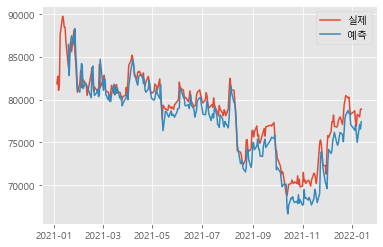

In [118]:
plt.plot(test['Adj Close'], label='실제')
plt.plot(test_pred, label='예측')
plt.legend()
plt.show()